# Lab 7: Decision Trees and Ensemble Methods

This week we will explore the use of decision trees for simple classification tasks. We will then look at how collections of decision trees (or other machine learning models) can trained on the same dataset and combined to enhance predictive performance. Specifically, we will look at bagging, random forests and boosting which are all related examples of ensemble methods.

Before starting, make sure to install the `graphviz` package installed using `conda install python-graphviz`. 

In [1]:
# %pylab inline

import numpy as np
# import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import random

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import graphviz

## 1) Decision Trees

Decision trees are a very simple machine learning technique that can be surprisingly powerful and offer a much more easily interpretable decision making process than many other methods. As the name suggests, decision trees are comprised of a set of nodes in a tree structure. All non-terminal nodes are called *decision nodes* which typically have two child nodes and contain a conditional expression involving a single feature of the input data. For a given input, starting at the root node, this condition is evaluated and this determines which of the two child nodes are selected for evaluation next. Once a *leaf node* is reached, the decision tree is able to produce an output class (classification) or a target value (regression). In this lab we will focus on the case of classification tasks.

For a given dataset of input-output pairs, there are a number of ways to construct a decision tree that can accurately classify the set of examples. We will be using the implementation of decision trees from the scikit-learn library which uses the CART (Classification And Regression Tree) algorithm with the Gini impurity criterion (see [this](https://victorzhou.com/blog/gini-impurity/) for simple explanation of Gini impurity). This algorithm can be summarised as follows:
1. **Obtaining the root node**: Test the possible splits of the dataset using conditions involving each of the input features and measure the Gini impurity of each split. The root node is given by the split that minimises the weighted sum of the Gini impurities of the two branches. The weights are equal to the number of data points that satisfy the condition of the corresponding branch.
2. **Creating the remaining decision nodes**: Iteratively follow the same process as step 1 using only the data points that match the conditions necessary to reach this point in the tree.
3. **Creating the Leaf nodes**: These nodes are created when one of the stopping criteria is met. This set of criteria includes the case where all points of each class have been completely separated by a split (i.e. when the impurity is 0) or when some maximum depth has been reached.

### 1.1) Training a Decision Tree Classifier

To start off, we will load in a classification dataset from scikit-learn: [the famous iris flower dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html#sphx-glr-auto-examples-datasets-plot-iris-dataset-py), compiled by Ronald Fisher in 1936. This is often used as a toy dataset for machine learning and contains three classes (species of Iris) with a number of named features such as petal length and width. The code below loads in the iris dataset but also includes the code to load in several other datasets that you can test your decision tree or ensemble methods on. These are commented out for now but you may wish to explore them later.

In [289]:
dataset = datasets.load_iris()
#dataset = datasets.load_wine()
#dataset = datasets.load_digits()

X = np.array(dataset['data'])
X_feature_names = dataset['feature_names']
y = np.array(dataset['target'])
y_target_names = dataset['target_names']

# 60% training, 20% dev and 20% test
random.seed(8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.25)

### 1.1) Training a Decision Tree Classifier

Use scikit-learn to train a [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier), with the name `model`, on the Iris dataset and compute its accuracy score on both the training and test set.

In [290]:
# write your code here
model = DecisionTreeClassifier()

model.fit(X_train, y_train)

print(f"train score: {model.score(X_train, y_train)}")
print(f"test score: {model.score(X_test, y_test)}")


train score: 1.0
test score: 0.8666666666666667


Is the model overfitting to the training data?

### 1.2) Visualise the tree

The code below has been provided to create a visualisation for your decision tree. This cell will also print out a number of examples from the test set along with your tree's predictions to help you understand how the classification is being made. Run the cell and try to answer the questions that follow.

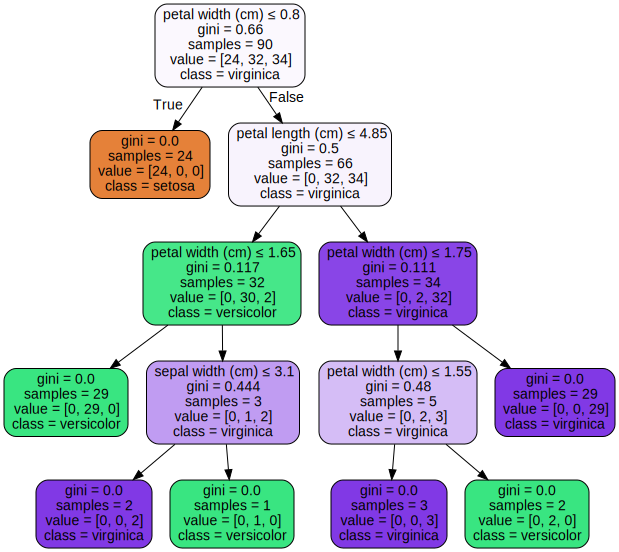

sepal length (cm) | sepal width (cm)  | petal length (cm) | petal width (cm)  | Label             | Prediction
--------------------------------------------------------------------------------------------------------------
4.9               | 3.0               | 1.4               | 0.2               | setosa            | setosa
6.4               | 2.8               | 5.6               | 2.1               | virginica         | virginica
6.0               | 2.2               | 4.0               | 1.0               | versicolor        | versicolor
6.0               | 3.4               | 4.5               | 1.6               | versicolor        | versicolor
5.4               | 3.7               | 1.5               | 0.2               | setosa            | setosa
7.2               | 3.0               | 5.8               | 1.6               | virginica         | versicolor
4.8               | 3.0               | 1.4               | 0.3               | setosa            | setosa
6.9           

In [4]:
# Visualise the Decision Tree
dot_data = sklearn.tree.export_graphviz(model, out_file=None, feature_names=X_feature_names, class_names=y_target_names, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)
graph.render("iris")
display(graph)

# Print examples from the test dataset
wdth = max([len(name) for name in X_feature_names] + [len(lab) for lab in y_target_names]) + 1
print('| '.join([f'{X_feature_names[i]: <{wdth}}' for i in range(len(X_feature_names))] + [f'{"Label":<{wdth}}', "Prediction"]))
print('-'*110)
predicted_labels = model.predict(X_test)
num_examples = 15
for example, label, predicted_label in zip(X_test[:num_examples], y_test[:num_examples], predicted_labels[:num_examples]):
    print('| '.join([f'{example[i]: <{wdth}}' for i in range(len(example))] + [f'{y_target_names[label]: <{wdth}}', f'{y_target_names[predicted_label]}']))

Try to answer the following questions for your tree (note that taking the left path from a decision node corresponds to the condition in that node being true):
1. What features are most informative for identifying the Iris Setosa species and what values must they have? 
2. What features can be used to discriminate between Iris Virginica and Iris Versicolor if the petals are longer than 4.75cm (hint: look at the paths through the decision tree from root to leaf)?
3. Choose one of the examples from the data set and follow the path that would be taken by the decision tree to produce a classification.
4. If we had more training data, which decision nodes do you think are most likely to change (hint: look at numbers of samples)?
5. Which decision nodes do you think may lead to the most errors if we deploy this model on a new test dataset? 

### 1.3) Train a decision tree for MNIST

For the iris dataset, we saw that our classifier was able to perform extremely well because of the dataset's simplicity. In this section, we will try to apply a decision tree to a more challenging dataset, the MNIST handwritten digits (as seen in week 5).

In [294]:
# load the MNIST data
X_mnist, y_mnist = fetch_openml(name='mnist_784',return_X_y=True)
random.seed(5)
frac_of_dataset = 0.5
index = int(frac_of_dataset*X_mnist.shape[0])
X_mnist = np.array(X_mnist)
y_mnist = np.array(y_mnist)
X_train, X_test, y_train, y_test = train_test_split(X_mnist[:index,:], y_mnist[:index], test_size=0.2)

Just like you did before, create and train a decision tree using scikit-learn and using the variable name `model`.

In [14]:
# write your code to train a decision tree classifier here
model = DecisionTreeClassifier(random_state=0)

model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

### 1.4) Compute the model's accuracy on MNIST train and test sets 

Compare the performance on train and test sets.

In [18]:
# write your code here
print(f"train score: {model.score(X_train, y_train)}")
print(f"test score: {model.score(X_test, y_test)}")

train score: 1.0
test score: 0.844


Is the model overfitting on the MNIST data?

## 2) Bagging
The combination of models can often perform much better than the average individual, and sometimes better than the best individual. Ensemble methods are ways of combining multiple models together. For good performance, the models should be diverse to minimise the expected error of the ensemble.

Bagging or 'bootstrap aggregation' is a simple ensemble method that induces diversity by training $M$ models on different samples of the training set (with replacement) and combining predictions by taking the mean or majority vote. An approximate bagging algorithm is:
1. For $m = 1,...,M$ models:
    - Randomly sample $N$ data points with replacement from the training set
    - Learn a decision tree (CART algorithm) on the subset of points
2. A prediction can be obtained by taking the majority vote over the $M$ model outputs.

### 2.1) Train a bagging ensemble

Complete the code below to train a bagging ensemble by randomly sampling from the MNIST training dataset to train multiple decision tress. 

In [139]:
num_models = 50
sample_size = 5000  # training set size.
np.random.seed(0)

all_models = []
for m in range(num_models):
    # TODO
    # Sample with replacement from the training set. 
    # Each sample should contain sample_size data points chosen at random.
    # Hint: look at the documentation for numpy.random.choice().
    p = np.random.permutation(len(y_train))
    
    X_sample = X_train[p][:sample_size]
    y_sample = y_train[p][:sample_size]
    
    
    # TODO
    # train a decision tree classifier on the random sample.
    model = DecisionTreeClassifier(random_state=0)
    model.fit(X_sample, y_sample)
    
    all_models.append(model)


### 2.2) Implement bagging prediction

Complete the `bagging_predict` function and then run the next cell to create predictions from the bagging ensemble based on majority voting of the individual models. 

In [135]:
# count how many classifiers have voted for each class for each point in the test dataset.
def bagging_predict(test_data, all_models):
    votes = np.zeros((test_data.shape[0], len(all_models)), dtype=int)  # number of classes = 10.
    combined_predictions = np.zeros(test_data.shape[0])

    for idx, m in enumerate(all_models):
        # TODO
        # obtain the predictions from model m for the test data and
        # populate the votes vector
        predictions = m.predict(test_data)
        votes[:,idx] = predictions
        
    for test_point in range(votes.shape[0]):
        # TODO
        # determine the class with the most votes for each test point
        # and populate the combined_predictions 
        # hint use np.bincount
        count = np.bincount(votes[test_point])
        pred_class = np.where(count == max(count))[0][0]
        
        combined_predictions[test_point] = pred_class
    
    return combined_predictions

In [136]:
prediction = bagging_predict(X_test, all_models)
accuracy = np.count_nonzero(prediction==np.int64(y_test))/y_test.shape[0]
print("Test set accuracy: {}".format(accuracy))

Test set accuracy: 0.9242857142857143


How does the accuracy compare to a single decision tree? 

Investigate the effect of changing the `sample_size` and `num_models` hyperparameters.

## 3) Random Forests
With bagging, the base models (individual decision trees) make similar splits on the same features, meaning that their errors are correlated and this reduces the diversity of the ensemble and limits performance.

Random forests improve the diversity of the base models by limiting the number of features considered for determining each split in the decision tree. We can obtain the random forest by modifying the bagging algorithm above so that each split for each model uses only a random subset of features.

### 3.1) Implement Random Forest Training

Copy in your code for the bagging procedure and modify it to implement random forest. The outline code below shows you where to make the modifications.

In [295]:
num_models = 50
sample_size = 4000  # training set size.
feature_sample_size = 200
np.random.seed(0)

all_models = []
all_selected_features = []  # for each model, save the list of selected feature indexes.
for m in range(num_models):
    # TODO
    # copy in your code from the bagging exercise here to sample with replacement from the training set. 
    # Each sample should contain sample_size data points chosen at random.
    # Hint: look at the documentation for numpy.random.choice().
    p = np.random.permutation(len(y_train))
    
    X_sample = X_train[p][:sample_size]
    y_sample = y_train[p][:sample_size]

    # TODO
    # create a decision tree classifier with limited features considered
    # for each split
    model = DecisionTreeClassifier(random_state=0, max_features=feature_sample_size)
    
    # TODO
    # copy in your code from the bagging exercise here to train a decision tree classifier on the random sample.
    # Remember to train it only on the random sample of features.
    model.fit(X_sample, y_sample)
    
    
    all_models.append(model)

### 3.2) Random Forest Prediction

Use the `bagging_predict` function from Section 2.2 to generate predictions for the random forest and calculate the accuracy.

In [150]:
prediction = bagging_predict(X_test, all_models)
accuracy = np.count_nonzero(prediction==np.int64(y_test))/y_test.shape[0]
print("Test set accuracy: {}".format(accuracy))

Test set accuracy: 0.9311428571428572


How does the performance of the random forest compare to bagging and the single model? Can you improve the performance by changing the hyperparameters?

## 4) Boosting
We can use a decision tree classifier as the base model for the ensemble method known as boosting. Boosting involves training base models in sequence to ensure that each base model addresses the weaknesses of the ensemble. Instead of training a new base model on a random sample, we weight the data points in the training set according to the performance of previous base models.

AdaBoost (adaptive boosting) is a popular boosting method, where training examples that are misclassified by one of the base classifiers are given greater weight when used to train the next classifier in the sequence. Once all the classifiers have been trained, their predictions are then combined through a weighted majority voting scheme.

The AdaBoost algorithm which you will implement is given below:
1. Initialize the data weighting coefficients $w_n$ by setting $w_n^{(1)} = 1/N$ for $ n = 1,...,N$ where $N$ is the number of training examples
2. For $m = 1,...,M$ models:
    - Fit a classifier $y_m(x)$ to a subset of the training data by minimising the weighted error function (hint: specify the `sample_weight` when fitting the model using scikit-learn).
    - Calculate the weighted error, $\epsilon_m$, where $$\epsilon_m = 1 - \text{weighted_accuracy} = 1 - \frac{\sum_{n=1}^N{w_nI(y_m(x_n) = t_n)}}{\sum_{n=1}^N{w_n}}$$
    and $I$ is the indicator function that equals $1$ when the condition is true (hint: the computation for the weighted accuracy is done for you if `sample_weight` is specified when calling the [`score`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.score) function).
    - Calculate the model weighting coefficients, $\alpha_m$, where
    $$\alpha_m = ln\left(\frac{1-\epsilon_m}{\epsilon_m}\right)$$
    - Update the data weighting coefficients
    $$w_n^{(m+1)} = w_n^{(m)} exp(\alpha_m \space I(y_m(x_n) \neq t_n))$$ where, again, $I$ is the indicator function.
3. The final prediction is a weighted combination of the trained base classifiers weighted by $\alpha_m$.
    
For more information on boosting, see Bishop section 14.3.

### 4.1) Train an ensemble model using the AdaBoost algorithm

In [296]:
num_models = 200 # number of base classifiers
sample_size = 2000  # sample training set size.

# TODO
# initialise the sample weights for all data points in the training set.
sample_weights = [1/sample_size] * sample_size

alphas = []
all_models = []
for m in range(num_models):
    # TODO
    # copy in your code from the bagging exercise here to sample with replacement from the training set. 
    # Each sample should contain sample_size data points chosen at random.
    # Hint: look at the documentation for numpy.random.choice().
    p = np.random.permutation(len(y_train))
    
    X_sample = X_train[p][:sample_size]
    y_sample = y_train[p][:sample_size]

    
    # TODO
    # train a decision tree classifier on the weighted random sample.
    # Consider setting the max_depth hyperparameter
    # Hint: fit() takes an additional argument, 'sample_weight'.
    model = DecisionTreeClassifier(random_state=0, max_depth=10)
    
    model.fit(X_sample, y_sample, sample_weight=sample_weights)
    
    # TODO
    # compute the model error using weighted accuracy for the sampled training dataset
    # Hint: score() score takes an additional argument, 'sample_weight'.
    error = (1 - model.score(X_sample, y_sample, sample_weight=sample_weights)) + np.finfo(float).eps
    
    # TODO
    # calculate alpha for the model and append alpha to alphas
    alphas.append(np.log((1 - error) / error))
    
    # TODO
    # update the sample_weights for incorrect predictions using alpha
    predictions = model.predict(X_sample)
    
    sample_weights = [(w * np.exp(alphas[m] * (0 if predictions[i] == y_sample[i] else 1))) for (i, w) in enumerate(sample_weights)]
    
    all_models.append(model)

### 4.2) Adaboost prediction
Complete the `boosting_predict` function to produce predictions from the trained models. In addition to the test data and the trained models, the function also takes the list of $\alpha_m$ as an input which determines the weighting of each individual model on the overall output.

In [297]:
def boosting_predict(test_data, all_models, alphas):
    votes = np.zeros((test_data.shape[0], len(all_models)), dtype=int) 
    combined_predictions = np.zeros(test_data.shape[0])

    for idx, m in enumerate(all_models):
        # TODO
        # write your code here to obtain the predictions from model m and store it in votes.
        predictions = m.predict(test_data)
        votes[:,idx] = predictions
        
    
    for test_point in range(len(votes)):
        # TODO
        # determine the class with the most votes for each test point and store it in combined_predictions
        # hint: remember the weighting alpha
        count = np.bincount(votes[test_point])
        count = [val * alphas[i] for i, val in enumerate(count)]
        
        pred_class = np.where(count == max(count))[0][0]
        
        combined_predictions[test_point] = pred_class
        
    
    return combined_predictions

In [298]:
prediction = boosting_predict(X_test, all_models, alphas)
accuracy = np.count_nonzero(prediction==np.int64(y_test))/y_test.shape[0]
print("Test set accuracy: {}".format(accuracy))

Test set accuracy: 0.9198571428571428


How does performance compare with the other approaches?

Try out different values of `sample_size`, `num_models` and `max_depth` of the decision tree.

How does training time vary for each approach as you change these ensemble parameters? 

## Wrap up

We trained and visualised a decision tree classifier, which showed how decision trees can provide an interpretable model for classification. We then implemented bagging to improve performance, then extended it to the Random Forest and Boosting methods. This should give some idea of how these three key ensemble methods are related to one another. Random Forest adds random sampling over features, while boosting re-weights the dataset at each iteration to focus on misclassified data points.

### References
- COMS30035 Machine Learning lecture notes.
- Bishop Pattern Recognition and Machine Learning: Chapter 14.

#### Materials used to create the lab
- https://github.com/TrainingByPackt/Applied-Supervised-Learning-with-Python/blob/master/Chapter%204%20-%20Classification/Exercise%2042%20-%20Iris%20Classification%20Using%20a%20CART%20Decision%20Tree.ipynb
- https://plsms.github.io/kaggle/learn/2%20Machine%20Learning/Level%201/11%20Exercise;%20Random%20Forests.html
- https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
- https://www.kaggle.com/jmohitj/practicing-playing-with-mnist-decision-tree
